In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import matplotlib.pyplot as plt


In [ ]:
##LDA##
df_all = pd.read_csv("C:/Users/BREIN/Desktop/copathology_visualization_temp/data/260108_wsev_final_df.csv")
hc_df = df_all[df_all['DX'] == 'HC']
df = df_all[df_all['DX'] != 'HC']
region_cols = df_all.loc[:, 'ctx_lh_caudalanteriorcingulate':'ctx_rh_insula'].columns

X_hc = hc_df[region_cols].values.astype(float)
X_pat = df[region_cols].values.astype(float)

print(f"HC: {X_hc.shape[0]} subjects")
print(f"Patients: {X_pat.shape[0]} subjects")
y = df['DX'].values

hc_mean = X_hc.mean(axis=0, keepdims=True)
hc_std  = X_hc.std(axis=0, keepdims=True) + 1e-8  # avoid divide-by-zero

Z = (X_pat - hc_mean) / hc_std
X_atrophy = np.maximum(-Z, 0.0)
X = X_atrophy
X[X < 0] = 0.0

n_topics = 6
lda = LatentDirichletAllocation(
    n_components=n_topics,
    doc_topic_prior=1.0,
    topic_word_prior=0.1,
    learning_method='batch',
    max_iter=500,
    random_state=42
)

theta = lda.fit_transform(X)   # subject × topic
beta = lda.components_                 # topic × region

print("LDA fitted.")



In [13]:
## XGBOOST ##
# takes lda_subject_weights.csv as input
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

theta_df = pd.read_csv('C:/Users/BREIN/Desktop/copathology_visualization_temp/vanilla_LDA/wsev_results/lda_subject_topic_weights.csv')

topic_cols = [col for col in theta_df.columns if col.startswith("Topic_")]
X = theta_df[topic_cols].values
y = theta_df["DX"].values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y_encoded, theta_df.index, test_size=0.2, random_state=42, stratify=y
)

xgb_soft = XGBClassifier(
    objective="multi:softprob",  # outputs probability for each class
    num_class=len(np.unique(y_encoded)),
    eval_metric="mlogloss",
    use_label_encoder=False
)
xgb_soft.fit(X_train, y_train)
y_pred_soft = xgb_soft.predict(X_test)
y_proba_soft = xgb_soft.predict_proba(X_test)  # shape: [n_samples, num_classes]

print("=== Multiclass softmax ===")
print(classification_report(y_test, y_pred_soft, target_names=le.classes_))
print("Predicted probabilities (softprob) for first 5 samples:\n", y_proba_soft[:5])


=== Multiclass softmax ===
              precision    recall  f1-score   support

          AD       0.64      0.64      0.64        11
         DLB       0.25      0.17      0.20         6
          PD       0.55      0.55      0.55        11
        SVAD       0.00      0.00      0.00         4

    accuracy                           0.44        32
   macro avg       0.36      0.34      0.35        32
weighted avg       0.45      0.44      0.44        32

Predicted probabilities (softprob) for first 5 samples:
 [[0.7051817  0.05177959 0.23801744 0.00502124]
 [0.01690536 0.44090003 0.49798718 0.04420741]
 [0.57376724 0.11522391 0.02095889 0.29004997]
 [0.01679039 0.06709496 0.9140957  0.00201889]
 [0.0300654  0.00549387 0.10325548 0.8611852 ]]


c:\Users\BREIN\anaconda3\envs\data_management\lib\site-packages\xgboost\training.py:183: UserWarning: [13:17:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


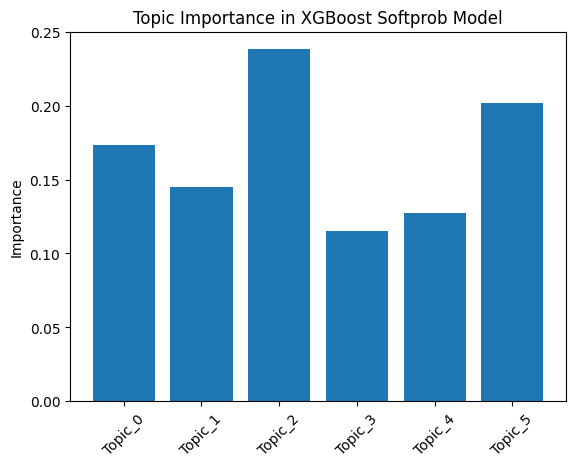

In [11]:
import matplotlib.pyplot as plt

importances = xgb_soft.feature_importances_
plt.bar(topic_cols, importances)
plt.xticks(rotation=45)
plt.ylabel("Importance")
plt.title("Topic Importance in XGBoost Softprob Model")
plt.show()


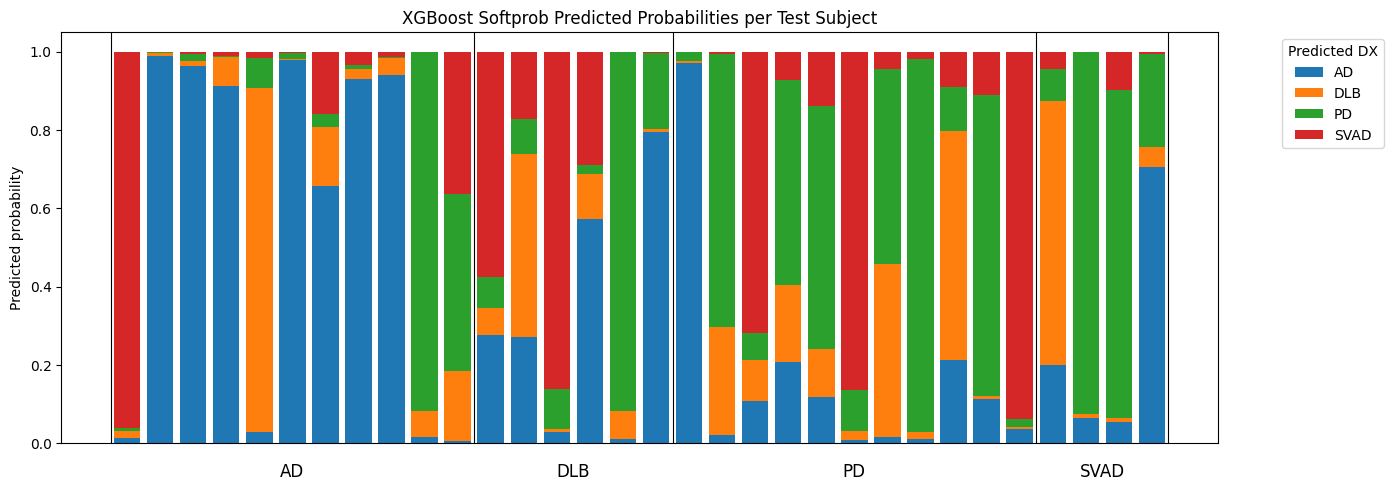

In [23]:
## XGBOOST TEST ##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# -------------------------
# Inputs
# -------------------------
# theta_df: DataFrame with Topic_* columns + "DX"
# xgb_soft: trained XGBClassifier
# le: LabelEncoder used on DX

topic_cols = [col for col in theta_df.columns if col.startswith("Topic_")]
X = theta_df[topic_cols].values
y = theta_df["DX"].values

# -------------------------
# 1. Split train/test
# # -------------------------
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, theta_df.index, test_size=0.2, random_state=42, stratify=y
)
# Topic weights for test set
theta_test_df = pd.DataFrame(
    X_test,
    columns=topic_cols
)

theta_test_df["DX_true"] = y_test
theta_test_df = theta_test_df.reset_index(drop=True)

# Sort by true DX (same logic as probabilities)
theta_test_df = theta_test_df.sort_values("DX_true").reset_index(drop=True)


# Predict probabilities on test set
y_proba_test = xgb_soft.predict_proba(X_test)
dx_classes = le.classes_
# Predicted DX as argmax of probabilities
y_pred_idx = np.argmax(y_proba_test, axis=1)
y_pred_dx = le.inverse_transform(y_pred_idx)

# Create test DataFrame
proba_test_df = pd.DataFrame(y_proba_test, columns=dx_classes)
proba_test_df["DX_true"] = y_test
proba_test_df['DX_pred'] = y_pred_dx
proba_test_df = proba_test_df.reset_index(drop=True)

# -------------------------
# 2. Sort test set by true DX
# -------------------------
proba_test_df = proba_test_df.sort_values("DX_true").reset_index(drop=True)
proba_test_df.to_csv('C:/Users/BREIN/Desktop/copathology_visualization_temp/lda_with_xg/testset_results.csv', index=False)

# # -------------------------
# # 3a. Heatmap for test set
# # -------------------------
# plt.figure(figsize=(12,6))
# sns.heatmap(
#     proba_test_df[dx_classes].values.T,  # transpose so DX classes on y-axis
#     cmap="Reds",
#     cbar_kws={"label": "Predicted probability"},
#     xticklabels=False
# )
# plt.yticks(np.arange(len(dx_classes)) + 0.5, dx_classes, rotation=0)
# plt.ylabel("Predicted DX")
# plt.title("XGBoost Softprob Predicted Probabilities per Test Subject")

# # Add DX subgroup labels along X-axis
dx_unique = proba_test_df["DX_true"].unique()
# current_idx = 0
# midpoints = []
# for dx in dx_unique:
#     count = sum(proba_test_df["DX_true"] == dx)
#     midpoints.append(current_idx + count/2)
#     current_idx += count

# plt.xticks(midpoints, dx_unique)
# plt.xlabel("Test subjects grouped by true DX")
# plt.tight_layout()
# plt.show()

# -------------------------
# 3b. Stacked bar for test set
# -------------------------
fig, ax = plt.subplots(figsize=(14,5))
bottom = np.zeros(len(proba_test_df))
colors = sns.color_palette("tab10", n_colors=len(dx_classes))

for i, dx in enumerate(dx_classes):
    ax.bar(
        np.arange(len(proba_test_df)),
        proba_test_df[dx],
        bottom=bottom,
        color=colors[i],
        label=dx
    )
    bottom += proba_test_df[dx].values

ax.set_xticks([])  # hide individual subjects
ax.set_ylabel("Predicted probability")
ax.set_title("XGBoost Softprob Predicted Probabilities per Test Subject")

# Add DX subgroup labels and vertical separators
current_idx = 0
for dx in dx_unique:
    count = sum(proba_test_df["DX_true"] == dx)
    ax.text(current_idx + count/2 - 0.5, -0.05, dx, ha='center', va='top', fontsize=12)
    ax.axvline(current_idx-0.5, color='black', linewidth=0.8)
    current_idx += count
ax.axvline(current_idx-0.5, color='black', linewidth=0.8)  # final line

ax.legend(title="Predicted DX", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


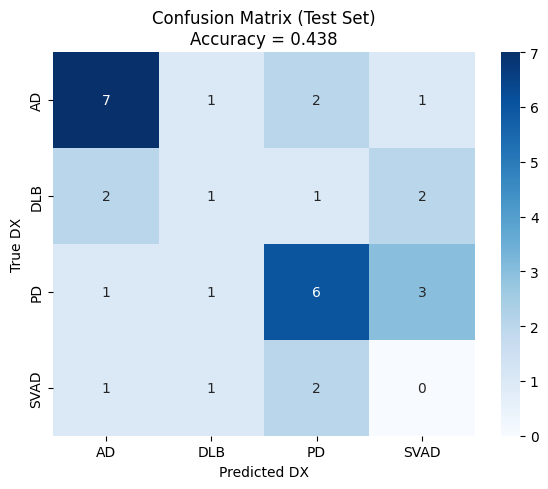

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_dx)
accuracy = np.trace(cm) / np.sum(cm)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
# disp.plot(cmap='Blues', values_format='d')  # or normalize=True for % values

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)

plt.xlabel("Predicted DX")
plt.ylabel("True DX")
plt.title(f"Confusion Matrix (Test Set)\nAccuracy = {accuracy:.3f}")
plt.tight_layout()
plt.show()


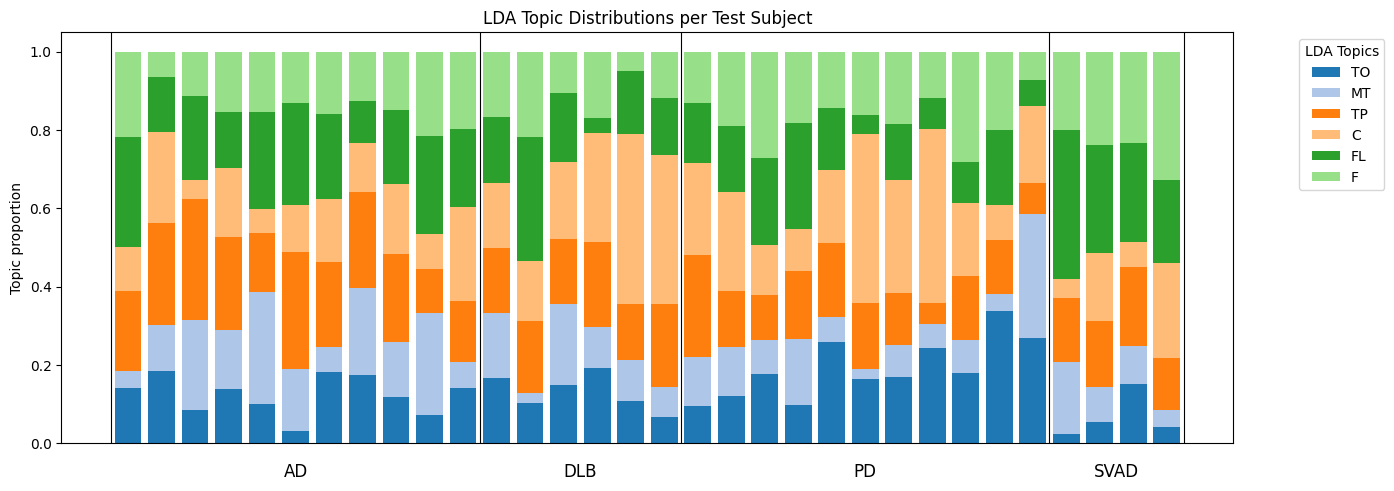

In [31]:
label_map = {'Topic_0': 'TO', 'Topic_1': 'MT', 'Topic_2': 'TP', 'Topic_3': 'C', 'Topic_4': 'FL', 'Topic_5': 'F'}

fig, ax = plt.subplots(figsize=(14,5))

bottom = np.zeros(len(theta_test_df))
topic_colors = sns.color_palette("tab20", n_colors=len(topic_cols))

for i, topic in enumerate(topic_cols):
    ax.bar(
        np.arange(len(theta_test_df)),
        theta_test_df[topic],
        bottom=bottom,
        color=topic_colors[i],
        label=label_map.get(topic, topic)  # ← relabeled here
    )
    bottom += theta_test_df[topic].values

ax.set_xticks([])
ax.set_ylabel("Topic proportion")
ax.set_title("LDA Topic Distributions per Test Subject")

# DX block labels and separators
dx_unique = theta_test_df["DX_true"].unique()
current_idx = 0

for dx in dx_unique:
    count = sum(theta_test_df["DX_true"] == dx)

    ax.text(
        current_idx + count/2 - 0.5,
        -0.05,
        dx,
        ha='center',
        va='top',
        fontsize=12
    )

    ax.axvline(current_idx - 0.5, color='black', linewidth=0.8)
    current_idx += count

ax.axvline(current_idx - 0.5, color='black', linewidth=0.8)

ax.legend(
    title="LDA Topics",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()